# **Bitmap Encoding**

## Steganography: Hiding Messages in Images

Steganography involves concealing messages within another medium, such as images, audio, or text. Unlike encryption, which disguises the content of a message, steganography hides its very existence. Modern digital steganography often leverages multimedia files, particularly images, due to their high data redundancy. This makes minor modifications, such as changing pixel values, imperceptible to the human eye.

### Least Significant Bit (LSB) Steganography
The most common technique in image steganography is **Least Significant Bit (LSB) embedding**, where the least significant bit of a pixel's color value is replaced with a bit from the secret message. For example:

```shell
Original: 11110010
Modified: 11110011
```

The change encodes a message bit while remaining visually undetectable. LSB steganography requires an agreed encoding scheme to identify where and how the data is hidden.

### Applications and Security Enhancements
Steganography is used for watermarking, secure communication, and metadata embedding. For added security, encryption methods like the Caesar Cipher can be applied to the message before embedding. Encoding the message in formats like Base64 ensures compatibility and reduces corruption risks.

### Why Images?
Images are ideal for steganography due to their pixel-level redundancy, enabling small changes without noticeable visual impact. Combining steganography with encryption provides an additional layer of security, ensuring even if the message is found, it remains indecipherable.

## Encoding a message in an image

### How To hide a message

1. **Choose an Image:** Any bitmap image can be used, but high-resolution images provide more space for hiding data. For this guide, we'll use a bitmap image of a cat.
2. **Prepare the Message:** The message will be encoded in Base64 before embedding to ensure compatibility and readability.
3. **Embed the Message:** Using LSB steganography, replace the least significant bits of the image's pixel data with bits from the encoded message.


```{admonition} Note
:class: note
You may need to update the `path` variable to point to the image you want to use.
```

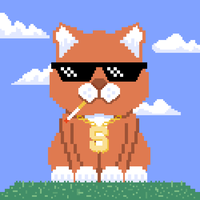

In [ ]:
from PIL import Image
from IPython.display import display
img = Image.open("cat.bmp")
display(img)

In [3]:
import os

path = os.getcwd()

def base64_encode(input_string):
    BASE64_CHARS = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+/"
    encoded_string = ""
    value = 0
    bits = -6
    base64_mask = 0x3F

    for character in input_string.encode():
        value = (value << 8) + character
        bits += 8

        while bits >= 0:
            encoded_string += BASE64_CHARS[(value >> bits) & base64_mask]
            bits -= 6
    
    if bits > -6:
        encoded_string += BASE64_CHARS[((value << 8) >> (bits + 8)) & base64_mask]
    
    while len(encoded_string) % 4:
        encoded_string += "="
    
    return encoded_string

# This will allow us to highlight the differences in the binary data
def highlight_changes(original, modified):
    highlighted_original = []
    highlighted_modified = []

    for o, m in zip(original, modified):
        if o != m:
            highlighted_original.append(f"[{o}]")
            highlighted_modified.append(f"[{m}]")
        else:
            highlighted_original.append(o)
            highlighted_modified.append(m)

    return ''.join(highlighted_original), ''.join(highlighted_modified)

def embed_message(data, message, offset):
    # Encode the message using Base64
    base64_message = base64_encode(message)
    print(f"Base64-encoded message: {base64_message}")
    print(f"Base64 length (in characters): {len(base64_message)}")

    binary_message = ''.join(format(ord(char), '08b') for char in base64_message)
    print(f"Binary message: {binary_message}")

    # Embed the length of the Base64 message (in bytes) in the first 32 bits
    length_bits = format(len(base64_message), '032b')
    print(f"Length bits: {length_bits}")

    data = bytearray(data)
    # Extract original binary at embedding positions
    original_binary = "".join(format(data[offset + i], '08b') for i in range(len(length_bits + binary_message)))
    modified_data = bytearray(data)

    # Embed the message into the least significant bits
    for i, bit in enumerate(length_bits + binary_message):
        modified_data[offset + i] = (modified_data[offset + i] & 0xFE) | int(bit)

    # Extract modified binary at embedding positions
    modified_binary = "".join(format(modified_data[offset + i], '08b') for i in range(len(length_bits + binary_message)))

    # Highlight changes
    highlighted_original, highlighted_modified = highlight_changes(original_binary, modified_binary)

    # Truncate for readability
    def truncate_binary(binary_str, show_bits=64):
        if len(binary_str) > show_bits * 2:
            return binary_str[:show_bits] + "..." + binary_str[-show_bits:]
        return binary_str

    print("\nOriginal binary data at embedding positions (truncated):")
    print(truncate_binary(highlighted_original))

    print("\nModified binary data at embedding positions (truncated):")
    print(truncate_binary(highlighted_modified))

    return modified_data


input_file_path = os.path.join(path, "cat.bmp")
output_file_path = os.path.join(path, "hiddencat.bmp")

with open(input_file_path, "rb") as f:
    data = f.read()

print("Enter the message to embed: ")
message_to_embed = input()
print(f"{message_to_embed}")

# Specify the offset where the pixel data starts (e.g., 54 for standard BMP)
pixel_data_offset = int.from_bytes(data[10:14], byteorder='little')

encoded_data = embed_message(data, message_to_embed, pixel_data_offset)

with open(output_file_path, "wb") as f:
    f.write(encoded_data)

print(f"Message embedded successfully in Base64! Encoded image saved as {output_file_path}.")

Enter the message to embed: 
Hi! I'm a cool cat!
Base64-encoded message: SGkhIEknbSBhIGNvb2wgY2F0IQ==
Base64 length (in characters): 28
Binary message: 01010011010001110110101101101000010010010100010101101011011011100110001001010011010000100110100001001001010001110100111001110110011000100011001001110111011001110101100100110010010001100011000001001001010100010011110100111101
Length bits: 00000000000000000000000000011100

Original binary data at embedding positions (truncated):
0110011[1]10001110010000100110011[1]10001110010000100110011[1]10...0110011[1]1000111[0]0100001[0]011001111000111[0]0100001001100111

Modified binary data at embedding positions (truncated):
0110011[0]10001110010000100110011[0]10001110010000100110011[0]10...0110011[0]1000111[1]0100001[1]011001111000111[1]0100001001100111
Message embedded successfully in Base64! Encoded image saved as /run/media/breezy/b1de4ffb-fd5e-4613-986d-b119a4c02043/GitHub/Jupyter-Books/cryptography-guide/steganography/hiddencat.bmp.


The comparison between the original and modified binary data highlights the subtle but precise changes made during the embedding process. Notice how the least significant bits (LSBs) of the original binary data are modified to encode the length and content of the hidden message. These alterations are so minor that they do not visibly affect the image, yet they securely store the message within its pixel data. This clever manipulation of binary values demonstrates the power of steganography, where seemingly insignificant details carry meaningful information—hidden in plain sight. By preserving the image's integrity while embedding a secret, this technique showcases how technology can be used creatively to protect and communicate information.

## Decoding a message from an image

### How to extract a hidden message

To retrieve the hidden message, the recipient must reverse the embedding process. This involves:

1. **Load the Image:** Open the image containing the hidden message.
2. **Extract the Message Length:** Retrieve the length of the hidden message from the least significant bits of the image's pixel data.
3. **Extract the Message:** Using the message length, extract the hidden message from the least significant bits of the image's pixel data.
4. **Decode the Message:** Decode the extracted message from Base64 to reveal the original content.


```{admonition} Note
:class: note
You may need to update the `path` variable to point to the image you want to use.
```

In [4]:
import os

path = os.getcwd()

def base64_decode(input_string):
    BASE64_CHARS = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+/"
    decoded_string = bytearray()
    value = 0
    bits = -8

    for character in input_string:
        if character not in BASE64_CHARS:
            if character == "=":
                break
            continue
        
        value = (value << 6) + BASE64_CHARS.index(character)
        bits += 6

        if bits >= 0:
            decoded_string.append((value >> bits) & 0xFF)
            bits -= 8
    
    return decoded_string.decode()

def extract_message(data, offset):
    # Extract the length of the Base64 message (first 32 bits)
    length_bits = ''.join(str(data[offset + i] & 1) for i in range(32))
    print(f"Length bits: {length_bits}")
    base64_length = int(length_bits, 2)
    print(f"Extracted Base64 length (in characters): {base64_length}")

    # Extract the Base64 message
    binary_message = ''.join(str(data[offset + 32 + i] & 1) for i in range(base64_length * 8))
    base64_message = ''.join(chr(int(binary_message[i:i+8], 2)) for i in range(0, len(binary_message), 8))
    print(f"Extracted Base64 message: {base64_message}")
    print(f"Extracted Binary message: {binary_message}")

    # Decode the Base64 message
    return base64_decode(base64_message)

encoded_file_path = os.path.join(path, "hiddencat.bmp")
with open(encoded_file_path, "rb") as f: data = f.read()

# Specify the offset where the pixel data starts (e.g., 54 for standard BMP)
pixel_data_offset = int.from_bytes(data[10:14], byteorder='little')

hidden_message = extract_message(data, pixel_data_offset)
print(f"Extracted message: {hidden_message}")


Length bits: 00000000000000000000000000011100
Extracted Base64 length (in characters): 28
Extracted Base64 message: SGkhIEknbSBhIGNvb2wgY2F0IQ==
Extracted Binary message: 01010011010001110110101101101000010010010100010101101011011011100110001001010011010000100110100001001001010001110100111001110110011000100011001001110111011001110101100100110010010001100011000001001001010100010011110100111101
Extracted message: Hi! I'm a cool cat!


The extracted message is identical to the original message, demonstrating the successful retrieval of the hidden information. By following the reverse process of the embedding algorithm, the recipient can recover the message without any visible changes to the image. This seamless integration of data within the image's pixel data showcases the elegance and effectiveness of LSB steganography as a method of secure communication.